# Import Libraries

In [47]:
import sqlite3

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn.feature_selection import f_classif

from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler

import copy

import os

import joblib

from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_curve

from sklearn.metrics import roc_auc_score

from sklearn.metrics import auc

from sklearn.metrics import roc_curve

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

import shap

# Read Data

In [2]:
con = sqlite3.connect(database='./data/lung_cancer.db')
cursor = con.cursor()

sql_query = """SELECT name FROM sqlite_master
  WHERE type='table';"""

cursor.execute(sql_query)
print("List of tables\n")
print(cursor.fetchall())

List of tables

[('lung_cancer',)]


### Findings

*   There is only 1 table, lung_cancer, in the database file.

# EDA

## Missing Values, Target Label

In [3]:
sql_query = 'select * from lung_cancer'

df = pd.read_sql_query(sql=sql_query, con=con)

In [4]:
df.head()

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence
0,1.468154e+16,42,Male,No,Not Present,Medium,73,69,2015,2020,No,None / Low,Right,1
1,1.271684e+18,72,Male,Yes,Not Present,High,50,42,2006,2012,Yes,Medium,Right,1
2,1.708068e+18,65,Male,Yes,Not Present,Low,65,75,1998,Still Smoking,Yes,None / Low,Right,0
3,3.555829e+17,67,Male,No,Not Present,High,69,58,2011,2014,No,None / Low,Right,1
4,1.684598e+18,54,Male,Yes,Not Present,Medium,46,40,1994,2017,Yes,None / Low,Right,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      10348 non-null  float64
 1   Age                     10348 non-null  int64  
 2   Gender                  10348 non-null  object 
 3   COPD History            9236 non-null   object 
 4   Genetic Markers         10348 non-null  object 
 5   Air Pollution Exposure  10345 non-null  object 
 6   Last Weight             10348 non-null  int64  
 7   Current Weight          10348 non-null  int64  
 8   Start Smoking           10348 non-null  object 
 9   Stop Smoking            10348 non-null  object 
 10  Taken Bronchodilators   9287 non-null   object 
 11  Frequency of Tiredness  10348 non-null  object 
 12  Dominant Hand           10348 non-null  object 
 13  Lung Cancer Occurrence  10348 non-null  int64  
dtypes: float64(1), int64(4), object(9)
mem

### Findings

*   The table has 10,348 rows and 14 columns
*   From a first glance, there are missing values in columns, COPD History,
Taken Bronchodilators

In [6]:
df.isnull().sum().sort_values(ascending=False)

COPD History              1112
Taken Bronchodilators     1061
Air Pollution Exposure       3
ID                           0
Age                          0
Gender                       0
Genetic Markers              0
Last Weight                  0
Current Weight               0
Start Smoking                0
Stop Smoking                 0
Frequency of Tiredness       0
Dominant Hand                0
Lung Cancer Occurrence       0
dtype: int64

In [7]:
temp_df = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['No. of NaN'])
temp_df

,No. of NaN
COPD History,1112
Taken Bronchodilators,1061
Air Pollution Exposure,3
ID,0
Age,0
Gender,0
Genetic Markers,0
Last Weight,0
Current Weight,0
Start Smoking,0


In [8]:
temp_df / len(df)

,No. of NaN
COPD History,0.107460
Taken Bronchodilators,0.102532
Air Pollution Exposure,0.000290
ID,0.000000
Age,0.000000
Gender,0.000000
Genetic Markers,0.000000
Last Weight,0.000000
Current Weight,0.000000
Start Smoking,0.000000


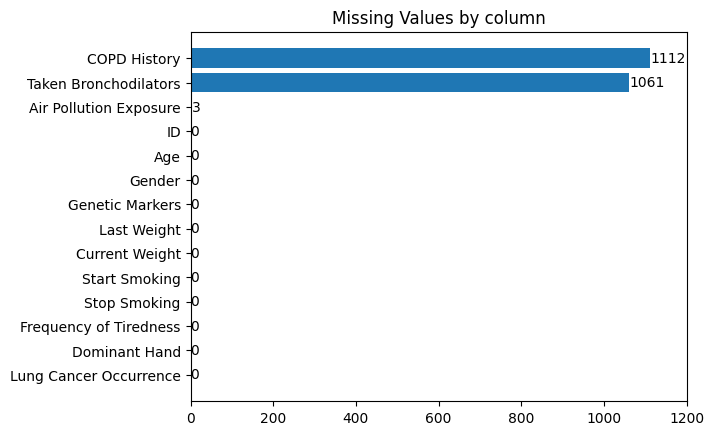

In [9]:
fig, ax = plt.subplots()

bars = plt.barh(y=temp_df.index, width=temp_df['No. of NaN'])

for bars in ax.containers:
    ax.bar_label(bars)

plt.xlim(0,1200)
plt.gca().invert_yaxis()
plt.title('Missing Values by column');

In [10]:
temp_df = pd.DataFrame(df['Lung Cancer Occurrence'].value_counts())
temp_df

,Lung Cancer Occurrence
1,5630
0,4718


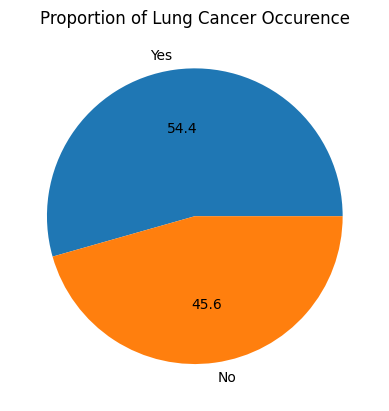

In [11]:
plt.pie(x = temp_df['Lung Cancer Occurrence'], autopct='%.1f', labels=['Yes', 'No'])
plt.title('Proportion of Lung Cancer Occurence');

### Findings

*   There are missing values in the columns, COPD History, Taken Bronchodilators and Air Pollution Exposure.
*   I will drop rows with missing values in Air Pollution Exposure due to the relatively low number of missing values, 3
*   For the missing values in the other columns, I will not drop the rows as they consitute at least 10% of the data, I will impute with the mode after doing train test split
*   This is because imputing before train test split will result in data leakage
*   In addition, the data set is imbalanced, I will turn on class weights during Machine Learning
*   Last but not least, I do not think the ID has any bearing if the patient will have lung cancer, I will drop that column

## Numerical Columns

In [12]:
df.head()

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence
0,1.468154e+16,42,Male,No,Not Present,Medium,73,69,2015,2020,No,None / Low,Right,1
1,1.271684e+18,72,Male,Yes,Not Present,High,50,42,2006,2012,Yes,Medium,Right,1
2,1.708068e+18,65,Male,Yes,Not Present,Low,65,75,1998,Still Smoking,Yes,None / Low,Right,0
3,3.555829e+17,67,Male,No,Not Present,High,69,58,2011,2014,No,None / Low,Right,1
4,1.684598e+18,54,Male,Yes,Not Present,Medium,46,40,1994,2017,Yes,None / Low,Right,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      10348 non-null  float64
 1   Age                     10348 non-null  int64  
 2   Gender                  10348 non-null  object 
 3   COPD History            9236 non-null   object 
 4   Genetic Markers         10348 non-null  object 
 5   Air Pollution Exposure  10345 non-null  object 
 6   Last Weight             10348 non-null  int64  
 7   Current Weight          10348 non-null  int64  
 8   Start Smoking           10348 non-null  object 
 9   Stop Smoking            10348 non-null  object 
 10  Taken Bronchodilators   9287 non-null   object 
 11  Frequency of Tiredness  10348 non-null  object 
 12  Dominant Hand           10348 non-null  object 
 13  Lung Cancer Occurrence  10348 non-null  int64  
dtypes: float64(1), int64(4), object(9)
mem

In [14]:
df['Age'][df['Age'] < 0]

46       -61
66       -69
82       -64
126      -46
243      -42
        ... 
10115    -69
10167    -71
10252    -76
10300    -61
10308   -101
Name: Age, Length: 229, dtype: int64

In [15]:
(df['Last Weight'] < 0).sum()

0

In [16]:
(df['Current Weight'] < 0).sum()

0

In [17]:
df['Start Smoking'].value_counts(dropna=False)

Not Applicable    672
2004              187
2016              185
2012              185
1997              181
                 ... 
1934                3
1930                2
1927                2
1923                1
1929                1
Name: Start Smoking, Length: 97, dtype: int64

In [18]:
df['Stop Smoking'].value_counts(dropna=False)

Still Smoking     2055
Not Applicable     672
2023               557
2022               446
2021               387
                  ... 
1941                 1
1940                 1
1939                 1
1933                 1
1948                 1
Name: Stop Smoking, Length: 84, dtype: int64

### Findings

*   There are 5 numerical columns, Age, Last Weight, Current Weight, Start Smoking, Stop Smoking
*   There is negative age in the Age, therefore I will perform an absolute value
*   Thankfully, there is no negative values in weight
*   I will feature engineer a new column, change in weight, subtracting Last Weight from Current Weight.
*   For rows with 'Still Smoking' in the column Stop Smoking, I will impute it with the current year, 2024.
*   In addition, the Start Smoking and Stop Smoking columns have the same number of 'Not Applicable' in them
*   These must be patients who do not smoke, I will perform a check if 'Not Applicable' are in the same rows for each column, if they are, I will convert 'Not Applicable' to the value zero
*   Before feature engineering, the columns Start Smoking and Stop Smoking have string in them therefore they are of the object type. I have to convert them to integer
*   Last but not least, I will feature engineer a new column, Years Smoke, by subtracting Start Smoking from Stop Smoking

## Categorical Columns

In [19]:
df.head()

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence
0,1.468154e+16,42,Male,No,Not Present,Medium,73,69,2015,2020,No,None / Low,Right,1
1,1.271684e+18,72,Male,Yes,Not Present,High,50,42,2006,2012,Yes,Medium,Right,1
2,1.708068e+18,65,Male,Yes,Not Present,Low,65,75,1998,Still Smoking,Yes,None / Low,Right,0
3,3.555829e+17,67,Male,No,Not Present,High,69,58,2011,2014,No,None / Low,Right,1
4,1.684598e+18,54,Male,Yes,Not Present,Medium,46,40,1994,2017,Yes,None / Low,Right,0


In [20]:
df['Gender'].value_counts()

Male      5653
Female    4152
MALE       324
FEMALE     218
NAN          1
Name: Gender, dtype: int64

### Findings

*   There is 1 NAN value in Gender column, I will drop it
*   The other issue, is some genders are all caps, I will capitalisation them

In [21]:
df['Genetic Markers'].value_counts(dropna=False)

Not Present    7785
Present        2563
Name: Genetic Markers, dtype: int64

In [22]:
df['Frequency of Tiredness'].value_counts(dropna=False)

None / Low    4813
Medium        2768
High          2767
Name: Frequency of Tiredness, dtype: int64

In [23]:
df['Dominant Hand'].value_counts(dropna=False)

Right        6895
Left         1747
RightBoth    1706
Name: Dominant Hand, dtype: int64

### Findings

*   The columns Genetic Markers and Frequency of Tiredness are all clean
*   However the column, Dominant Hand, has a value 'RightBoth', I will change it to both

# Summary
Below is the list of tasks to be done before feature selection, I will separate them into tasks to be done before train test split and task after


Before:

1.  Drop rows with missing values in Air Pollution Exposure
2.  Drop ID column
3.  Perform an absolute value of Age column
4.  Feature engineer a new column, change in weight, subtracting Last Weight from Current Weight and drop both initial columns, Current Weigh and Last Weight
4. Check if 'Not Applicable' in Start Smoking and Stop Smoking columns are the same rows
5.  Impute rows with 'Still Smoking' in the column Stop Smoking with 2024 and convert them to Integer. After that feature engineer a new column, Years Smoke, subtracting Start Smoking from Stop Smoking. Lastly, drop both initial columns
6.  Drop NAN value in Gender column
7.  Some gender are all caps in Gender column, capitalisation them
8.  There are values, 'RightBoth', in the 'Dominant Hand' column, change the value to 'Both'

After:
10.  Impute mode for missing values in COPD History and Taken Bronchodilators




In [24]:
df.head()

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence
0,1.468154e+16,42,Male,No,Not Present,Medium,73,69,2015,2020,No,None / Low,Right,1
1,1.271684e+18,72,Male,Yes,Not Present,High,50,42,2006,2012,Yes,Medium,Right,1
2,1.708068e+18,65,Male,Yes,Not Present,Low,65,75,1998,Still Smoking,Yes,None / Low,Right,0
3,3.555829e+17,67,Male,No,Not Present,High,69,58,2011,2014,No,None / Low,Right,1
4,1.684598e+18,54,Male,Yes,Not Present,Medium,46,40,1994,2017,Yes,None / Low,Right,0


### Task 1

In [25]:
df['Air Pollution Exposure'].isna().sum()

3

In [26]:
len(df)

10348

In [27]:
df = df.dropna(axis=0,
               subset=['Air Pollution Exposure'])

In [28]:
len(df)

10345

### Task 2

In [29]:
df = df.drop(columns='ID')

In [30]:
df.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence
0,42,Male,No,Not Present,Medium,73,69,2015,2020,No,None / Low,Right,1
1,72,Male,Yes,Not Present,High,50,42,2006,2012,Yes,Medium,Right,1
2,65,Male,Yes,Not Present,Low,65,75,1998,Still Smoking,Yes,None / Low,Right,0
3,67,Male,No,Not Present,High,69,58,2011,2014,No,None / Low,Right,1
4,54,Male,Yes,Not Present,Medium,46,40,1994,2017,Yes,None / Low,Right,0


### Task 3

In [31]:
(df['Age'] < 0).sum()

229

In [32]:
df['Age'] = abs(df['Age'])

In [33]:
(df['Age'] < 0).sum()

0

### Task 4

In [34]:
df['Change in Weight'] = df['Current Weight'] - df['Last Weight']
df = df.drop(columns=['Current Weight', 'Last Weight'])

In [35]:
df.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight
0,42,Male,No,Not Present,Medium,2015,2020,No,None / Low,Right,1,-4
1,72,Male,Yes,Not Present,High,2006,2012,Yes,Medium,Right,1,-8
2,65,Male,Yes,Not Present,Low,1998,Still Smoking,Yes,None / Low,Right,0,10
3,67,Male,No,Not Present,High,2011,2014,No,None / Low,Right,1,-11
4,54,Male,Yes,Not Present,Medium,1994,2017,Yes,None / Low,Right,0,-6


### Task 5

In [36]:
df[
(df['Stop Smoking'] == 'Not Applicable') & \
(df['Start Smoking'] == 'Not Applicable')
]

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight
17,74,Male,Yes,Present,Low,Not Applicable,Not Applicable,Yes,None / Low,Right,0,-9
23,45,Male,Yes,Not Present,Low,Not Applicable,Not Applicable,Yes,None / Low,Right,0,-6
24,70,Male,Yes,Not Present,Low,Not Applicable,Not Applicable,Yes,None / Low,Right,0,4
42,69,Male,Yes,Not Present,High,Not Applicable,Not Applicable,Yes,None / Low,Right,1,-5
43,56,Male,Yes,Not Present,Low,Not Applicable,Not Applicable,Yes,None / Low,Right,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
10290,61,Male,Yes,Not Present,High,Not Applicable,Not Applicable,Yes,None / Low,Right,1,-1
10302,74,Male,Yes,Not Present,High,Not Applicable,Not Applicable,Yes,None / Low,Right,0,7
10308,101,Female,No,Present,High,Not Applicable,Not Applicable,No,Medium,Right,1,-9
10315,44,Female,Yes,Present,High,Not Applicable,Not Applicable,Yes,High,Right,0,7


### Findings

*   The rows that have 'Not Applicable' in both Start Smoking and Stop Smoking columns are the same
*   I will proceed to replace 'Not Applicable' in both columns to the value 0

In [37]:
df['Stop Smoking'] = df['Stop Smoking'].replace(to_replace='Not Applicable', value=0)
df['Start Smoking'] = df['Start Smoking'].replace(to_replace='Not Applicable', value=0)

In [38]:
df[
(df['Stop Smoking'] == 'Not Applicable') & \
(df['Start Smoking'] == 'Not Applicable')
]

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight


### Task 6

In [39]:
(df['Stop Smoking'] == 'Still Smoking').sum()

2054

In [40]:
df['Stop Smoking'] = df['Stop Smoking'].replace(to_replace='Still Smoking', value=2024)

In [41]:
(df['Stop Smoking'] == 'Still Smoking').sum()

0

In [42]:
df['Start Smoking'] = df['Start Smoking'].astype(int)
df['Stop Smoking'] = df['Stop Smoking'].astype(int)

In [43]:
df['Years Smoke'] = df['Stop Smoking'] - df['Start Smoking']
df = df.drop(columns=['Start Smoking', 'Stop Smoking'])

In [44]:
df.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight,Years Smoke
0,42,Male,No,Not Present,Medium,No,None / Low,Right,1,-4,5
1,72,Male,Yes,Not Present,High,Yes,Medium,Right,1,-8,6
2,65,Male,Yes,Not Present,Low,Yes,None / Low,Right,0,10,26
3,67,Male,No,Not Present,High,No,None / Low,Right,1,-11,3
4,54,Male,Yes,Not Present,Medium,Yes,None / Low,Right,0,-6,23


In [45]:
df['Years Smoke'].value_counts()

0     1257
1      515
3      396
2      388
4      352
      ... 
88       2
87       1
89       1
91       1
83       1
Name: Years Smoke, Length: 91, dtype: int64

### Task 7

In [46]:
len(df)

10345

In [47]:
(df['Gender'] == 'NAN').sum()

1

In [48]:
df = df[df['Gender'] != 'NAN']

In [49]:
len(df)

10344

### Task 8

In [50]:
df['Gender'].value_counts()

Male      5650
Female    4152
MALE       324
FEMALE     218
Name: Gender, dtype: int64

In [51]:
df['Gender'] = df['Gender'].str.replace(pat='FEMALE', repl='Female', case=True)
df['Gender'] = df['Gender'].str.replace(pat='MALE', repl='Male', case=True)

In [52]:
df['Gender'].value_counts()

Male      5974
Female    4370
Name: Gender, dtype: int64

### Task 9

In [53]:
df['Dominant Hand'].value_counts(dropna=False)

Right        6893
Left         1745
RightBoth    1706
Name: Dominant Hand, dtype: int64

In [54]:
df['Dominant Hand'] = df['Dominant Hand'].str.replace(pat='RightBoth', repl='Both')

In [55]:
df['Dominant Hand'].value_counts(dropna=False)

Right    6893
Left     1745
Both     1706
Name: Dominant Hand, dtype: int64

### Task 10

Now I have to do train test split before imputing value

1.   I will set random_state = 42 to get reproducibility
2.   Test size will be 0.2
3.   In addition, I have to stratify because this is a binary classification

In [56]:
df.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight,Years Smoke
0,42,Male,No,Not Present,Medium,No,None / Low,Right,1,-4,5
1,72,Male,Yes,Not Present,High,Yes,Medium,Right,1,-8,6
2,65,Male,Yes,Not Present,Low,Yes,None / Low,Right,0,10,26
3,67,Male,No,Not Present,High,No,None / Low,Right,1,-11,3
4,54,Male,Yes,Not Present,Medium,Yes,None / Low,Right,0,-6,23


In [57]:
X = df.drop(columns='Lung Cancer Occurrence')
y = df['Lung Cancer Occurrence']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
X_train.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Change in Weight,Years Smoke
5439,66,Male,No,Not Present,High,No,None / Low,Right,-4,58
4083,78,Male,Yes,Not Present,High,Yes,None / Low,Both,4,48
80,54,Male,No,Not Present,High,No,High,Right,-8,23
4388,78,Female,No,Present,Low,No,High,Right,11,5
2361,78,Male,No,Not Present,High,No,Medium,Right,-4,7


In [60]:
X_test.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Change in Weight,Years Smoke
5003,66,Male,Yes,Not Present,High,Yes,None / Low,Right,-6,17
1418,70,Male,None,Not Present,Medium,None,High,Right,-13,57
2889,76,Female,None,Not Present,High,None,None / Low,Right,2,9
7806,70,Female,None,Not Present,High,No,High,Right,-5,15
1178,76,Male,None,Present,High,None,Medium,Both,-12,4


In [61]:
X_train['COPD History'].mode(dropna=True)[0]

'Yes'

In [62]:
X_train['Taken Bronchodilators'].mode(dropna=True)[0]

'Yes'

In [63]:
COPD_History_mode = X_train['COPD History'].mode(dropna=True)[0]
Taken_Bronchodilators_mode = X_train['Taken Bronchodilators'].mode(dropna=True)[0]

In [64]:
df['COPD History'] = df['COPD History'].fillna(value=COPD_History_mode)
df['Taken Bronchodilators'] = df['Taken Bronchodilators'].fillna(value=Taken_Bronchodilators_mode)

In [65]:
df.isna().sum()

Age                       0
Gender                    0
COPD History              0
Genetic Markers           0
Air Pollution Exposure    0
Taken Bronchodilators     0
Frequency of Tiredness    0
Dominant Hand             0
Lung Cancer Occurrence    0
Change in Weight          0
Years Smoke               0
dtype: int64

# Summary

*   The dataframe has been cleaned
*   Therefore, I can perform feature selection.
*   Train test split must be done before feature selection to prevent data leakage, using the same random_state and test_size
*   I will utilise a mixture of data visualisation and satistical methods
*   However before I begin, I will separate the feature selection into Numerical columns (which I will begin first) and categorical columns.



In [66]:
df.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight,Years Smoke
0,42,Male,No,Not Present,Medium,No,None / Low,Right,1,-4,5
1,72,Male,Yes,Not Present,High,Yes,Medium,Right,1,-8,6
2,65,Male,Yes,Not Present,Low,Yes,None / Low,Right,0,10,26
3,67,Male,No,Not Present,High,No,None / Low,Right,1,-11,3
4,54,Male,Yes,Not Present,Medium,Yes,None / Low,Right,0,-6,23


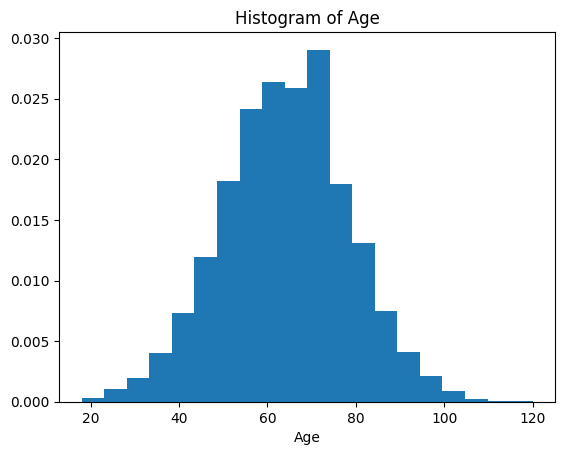

In [67]:
plt.hist(df['Age'], bins=20, density=True)
plt.title('Histogram of Age')
plt.xlabel('Age');

### Findings

*   People aged 50 - 80 make up the majority of the respondents

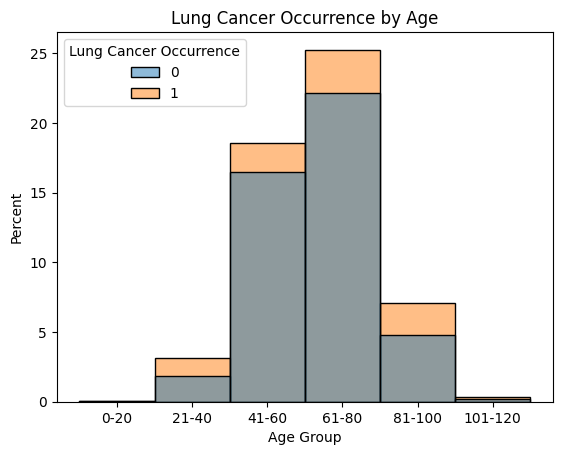

In [68]:
bins = [0,20,40,60,80,100,120]
labels = ['0-20','21-40', '41-60', '61-80', '81-100', '101-120']

df['Age Group'] = pd.cut(x=df['Age'], bins=bins, right=True, labels=labels)
sns.histplot(data=df, x='Age Group', hue='Lung Cancer Occurrence', stat='percent')
plt.title('Lung Cancer Occurrence by Age')
df = df.drop(columns='Age Group');

### Findings

*   Respondents between the age range 61-80 and 81-100 form the largest proportions of Lung Cancer patients

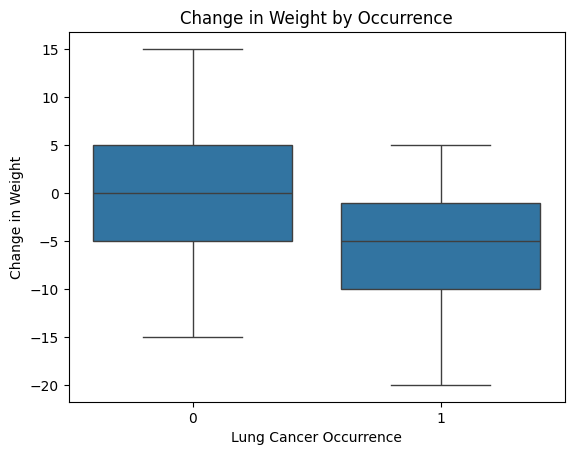

In [69]:
sns.boxplot(data=df, x='Lung Cancer Occurrence', y='Change in Weight')
plt.title('Change in Weight by Occurrence');

### Findings

*   Respondents who lose more weight are more likely to get lung cancer
*   People who have lung cancer have a lower median change in weight relative to people who do not

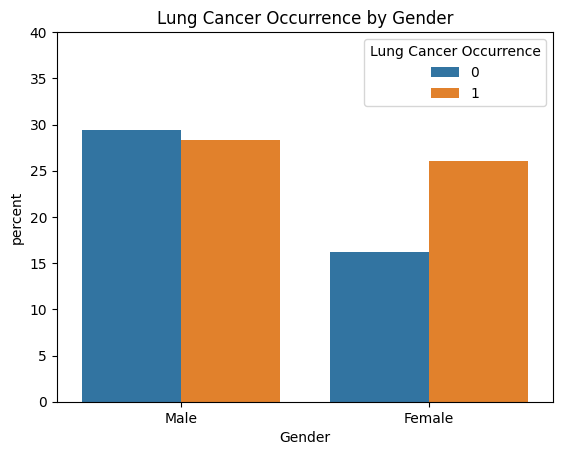

In [70]:
sns.countplot(data=df, x='Gender', hue='Lung Cancer Occurrence', stat='percent')
plt.title('Lung Cancer Occurrence by Gender')
plt.ylim(0,40);

### Findings

*   There is a higher percentage of males compare to females who get lung cancer
*   However, what is suprising, among females, there are more lung cancer occurrence than not

In [71]:
df.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight,Years Smoke
0,42,Male,No,Not Present,Medium,No,None / Low,Right,1,-4,5
1,72,Male,Yes,Not Present,High,Yes,Medium,Right,1,-8,6
2,65,Male,Yes,Not Present,Low,Yes,None / Low,Right,0,10,26
3,67,Male,No,Not Present,High,No,None / Low,Right,1,-11,3
4,54,Male,Yes,Not Present,Medium,Yes,None / Low,Right,0,-6,23


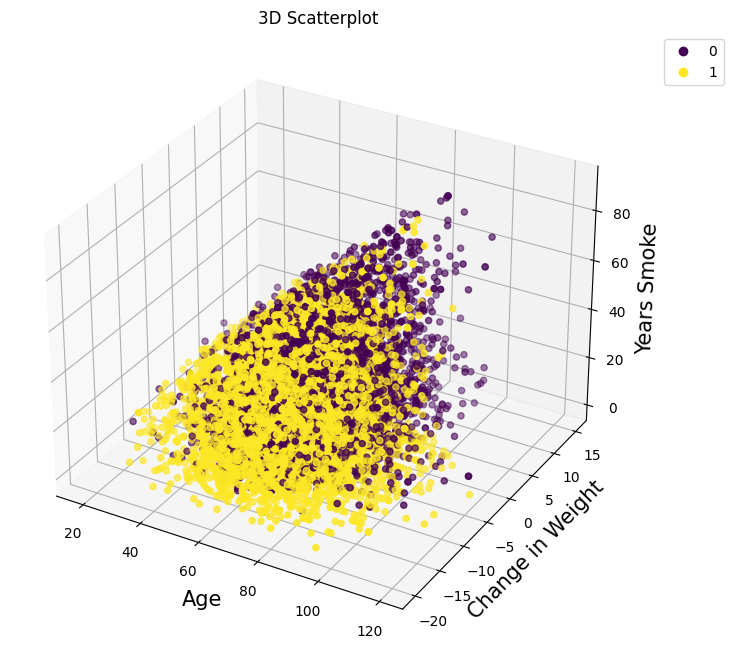

In [72]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection ="3d")

sc = ax.scatter3D(data=df, xs='Age', ys='Change in Weight', zs='Years Smoke', c='Lung Cancer Occurrence')
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Change in Weight', fontsize=15)
ax.set_zlabel('Years Smoke', fontsize=15)

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title('3D Scatterplot');

### Findings

*   No clear relationship can be gleaned from the columns Age, Change in Weight and Years Smoke against Lung Occurrence
*   However, it could be due to the complexity of the graph that no clear relationship is observed

# Feature Selection

In [73]:
df.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight,Years Smoke
0,42,Male,No,Not Present,Medium,No,None / Low,Right,1,-4,5
1,72,Male,Yes,Not Present,High,Yes,Medium,Right,1,-8,6
2,65,Male,Yes,Not Present,Low,Yes,None / Low,Right,0,10,26
3,67,Male,No,Not Present,High,No,None / Low,Right,1,-11,3
4,54,Male,Yes,Not Present,Medium,Yes,None / Low,Right,0,-6,23


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10344 entries, 0 to 10347
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     10344 non-null  int64 
 1   Gender                  10344 non-null  object
 2   COPD History            10344 non-null  object
 3   Genetic Markers         10344 non-null  object
 4   Air Pollution Exposure  10344 non-null  object
 5   Taken Bronchodilators   10344 non-null  object
 6   Frequency of Tiredness  10344 non-null  object
 7   Dominant Hand           10344 non-null  object
 8   Lung Cancer Occurrence  10344 non-null  int64 
 9   Change in Weight        10344 non-null  int64 
 10  Years Smoke             10344 non-null  int32 
dtypes: int32(1), int64(3), object(7)
memory usage: 929.3+ KB


In [75]:
X = df.drop(columns='Lung Cancer Occurrence')
y = df['Lung Cancer Occurrence']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [77]:
X_train.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Change in Weight,Years Smoke
5439,66,Male,No,Not Present,High,No,None / Low,Right,-4,58
4083,78,Male,Yes,Not Present,High,Yes,None / Low,Both,4,48
80,54,Male,No,Not Present,High,No,High,Right,-8,23
4388,78,Female,No,Present,Low,No,High,Right,11,5
2361,78,Male,No,Not Present,High,No,Medium,Right,-4,7


In [78]:
y_train

5439    0
4083    0
80      1
4388    0
2361    1
       ..
7649    0
1289    1
2875    0
9657    0
5494    0
Name: Lung Cancer Occurrence, Length: 8275, dtype: int64

In [79]:
X_train_merged = pd.concat(objs=[X_train, pd.DataFrame(data=y_train, columns=['Lung Cancer Occurrence'])],
                           axis=1)

In [80]:
X_train_merged.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Change in Weight,Years Smoke,Lung Cancer Occurrence
5439,66,Male,No,Not Present,High,No,None / Low,Right,-4,58,0
4083,78,Male,Yes,Not Present,High,Yes,None / Low,Both,4,48,0
80,54,Male,No,Not Present,High,No,High,Right,-8,23,1
4388,78,Female,No,Present,Low,No,High,Right,11,5,0
2361,78,Male,No,Not Present,High,No,Medium,Right,-4,7,1


## Numerical Columns

*   I will perform ANNOVA F-value on Numerical Features

In [81]:
numerical_features = ['Age', 'Change in Weight', 'Years Smoke']

f_value = f_classif(X_train_merged[numerical_features], X_train_merged['Lung Cancer Occurrence'])

In [82]:
temp_df = pd.DataFrame(data=f_value[0], index=numerical_features, columns=['F-Value']).sort_values(by='F-Value')
temp_df

,F-Value
Age,0.349496
Years Smoke,3.374548
Change in Weight,1545.676745


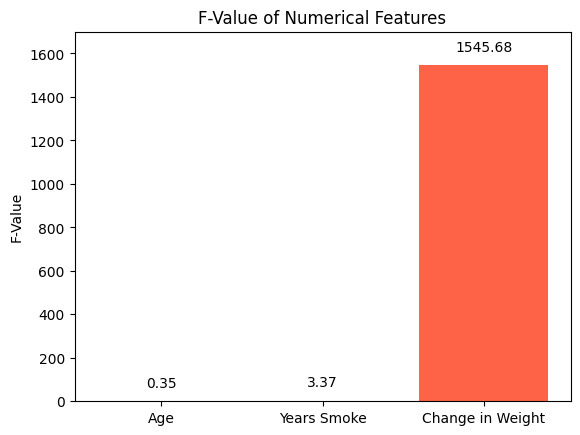

In [83]:
ax = plt.bar(x=temp_df.index, height=temp_df['F-Value'], color='tomato')

for x,y in zip(temp_df.index, temp_df['F-Value']):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.ylim(0,1700)
plt.ylabel('F-Value')
plt.title('F-Value of Numerical Features');

### Findings

*   The Change in Weight has the greatest variance among numerical features therefore I will keep it and drop the other numerical columns

## Categorical Columns

*   I have 2 options to convert categorical columns to numerical features, Label Encoding and 1 Hot encoding
*   I will perform label encoding and set drop_first (to reduce the number of columns) as true on the columns, Gender, COPD History, Genetic Markers, Taken Bronchodilators and Dominant Hand. The reason for this because these columns have binary values.
*   Label Encoding will be done on the columns Air Pollution Exposure and Frequency of Tiredness. This is done so that the models can capture that the higher the value, the higher/lower the likelihood of getting Lung Cancer
*   I will utilise the Chi Squared test on categorical columns

In [84]:
X_train_merged.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Change in Weight,Years Smoke,Lung Cancer Occurrence
5439,66,Male,No,Not Present,High,No,None / Low,Right,-4,58,0
4083,78,Male,Yes,Not Present,High,Yes,None / Low,Both,4,48,0
80,54,Male,No,Not Present,High,No,High,Right,-8,23,1
4388,78,Female,No,Present,Low,No,High,Right,11,5,0
2361,78,Male,No,Not Present,High,No,Medium,Right,-4,7,1


In [85]:
X_train_merged['Air Pollution Exposure'] = X_train_merged['Air Pollution Exposure'].replace(to_replace='Low', value=1)
X_train_merged['Air Pollution Exposure'] = X_train_merged['Air Pollution Exposure'].replace(to_replace='Medium', value=2)
X_train_merged['Air Pollution Exposure'] = X_train_merged['Air Pollution Exposure'].replace(to_replace='High', value=3)

X_train_merged['Frequency of Tiredness'] = X_train_merged['Frequency of Tiredness'].replace(to_replace='None / Low', value=1)
X_train_merged['Frequency of Tiredness'] = X_train_merged['Frequency of Tiredness'].replace(to_replace='Medium', value=2)
X_train_merged['Frequency of Tiredness'] = X_train_merged['Frequency of Tiredness'].replace(to_replace='High', value=3)

In [86]:
X_train_merged = pd.get_dummies(data=X_train_merged, drop_first=True)

In [87]:
X_train_merged.head()

,Age,Air Pollution Exposure,Frequency of Tiredness,Change in Weight,Years Smoke,Lung Cancer Occurrence,Gender_Male,COPD History_Yes,Genetic Markers_Present,Taken Bronchodilators_Yes,Dominant Hand_Left,Dominant Hand_Right
5439,66,3,1,-4,58,0,1,0,0,0,0,1
4083,78,3,1,4,48,0,1,1,0,1,0,0
80,54,3,3,-8,23,1,1,0,0,0,0,1
4388,78,1,3,11,5,0,0,0,1,0,0,1
2361,78,3,2,-4,7,1,1,0,0,0,0,1


In [88]:
chi2_scores = chi2(X=X_train_merged.drop(columns=['Age', 'Years Smoke', 'Change in Weight','Lung Cancer Occurrence']),
                   y=X_train_merged['Lung Cancer Occurrence'])
chi2_scores

(array([3.80642019e+01, 1.20378198e+00, 5.87653684e+01, 2.39804171e+00,
        2.26709581e+02, 2.69249494e+00, 1.55250435e+00, 7.69500412e-02]),
 array([6.84546260e-10, 2.72567090e-01, 1.77640586e-14, 1.21487245e-01,
        3.11135858e-51, 1.00821836e-01, 2.12766112e-01, 7.81473976e-01]))

In [89]:
chi2_values = pd.DataFrame(data=chi2_scores[0],
                           index=X_train_merged.drop(columns=['Age', 'Years Smoke', 'Change in Weight','Lung Cancer Occurrence']).columns,
                           columns=['Chi Squared Values']). \
                           sort_values(by='Chi Squared Values',
                                       ascending=False)
chi2_values

,Chi Squared Values
Genetic Markers_Present,226.709581
Gender_Male,58.765368
Air Pollution Exposure,38.064202
Taken Bronchodilators_Yes,2.692495
COPD History_Yes,2.398042
Dominant Hand_Left,1.552504
Frequency of Tiredness,1.203782
Dominant Hand_Right,0.076950


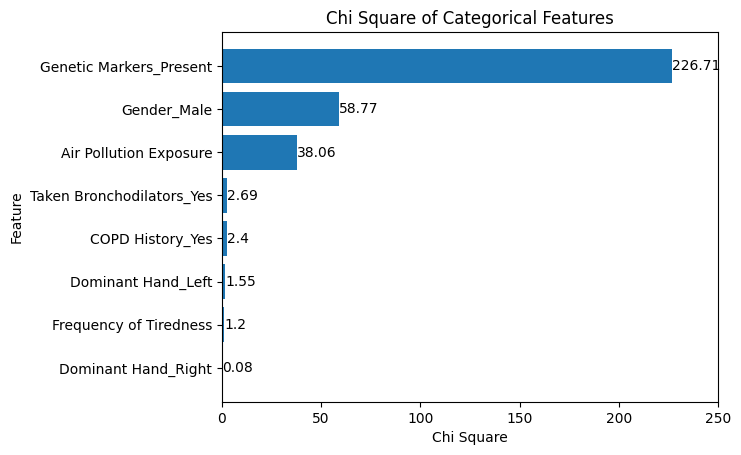

In [90]:
fig, ax = plt.subplots()

bars = plt.barh(y=chi2_values.index, width=round(chi2_values['Chi Squared Values'], 2))

for bars in ax.containers:
    ax.bar_label(bars)

plt.xlim(0,250)
plt.gca().invert_yaxis()
plt.title('Chi Square of Categorical Features')
plt.xlabel('Chi Square')
plt.ylabel('Feature');

### Findings

*   Genetic Markers_Present, Gender_Male and Air Pollution Exposure	display the greatest Chi squared values relatively to the rest of the categorical features
*   I will keep these 3 columns and drop the rest

# Summary
Below are the columns I will need to drop:

1.  Age
2.  Years Smoke
3.  Taken Bronchodilators
4.  COPD History
5.  Dominant Hand
6.  Frequency of Tiredness

After dropping the columns below are the next tasks in sequential order:

7. Since Air Pollution Exposure is label encoded, I will have to do the same
8. Gender and Genetic Markers will have to be one hot encoded will drop first set to True

In [91]:
df.head()

,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Change in Weight,Years Smoke
0,42,Male,No,Not Present,Medium,No,None / Low,Right,1,-4,5
1,72,Male,Yes,Not Present,High,Yes,Medium,Right,1,-8,6
2,65,Male,Yes,Not Present,Low,Yes,None / Low,Right,0,10,26
3,67,Male,No,Not Present,High,No,None / Low,Right,1,-11,3
4,54,Male,Yes,Not Present,Medium,Yes,None / Low,Right,0,-6,23


In [92]:
df = df.drop(columns=['Age', 'Years Smoke', 'Taken Bronchodilators', 'COPD History', 'Dominant Hand', 'Frequency of Tiredness'])

In [93]:
df.head()

,Gender,Genetic Markers,Air Pollution Exposure,Lung Cancer Occurrence,Change in Weight
0,Male,Not Present,Medium,1,-4
1,Male,Not Present,High,1,-8
2,Male,Not Present,Low,0,10
3,Male,Not Present,High,1,-11
4,Male,Not Present,Medium,0,-6


In [94]:
df['Air Pollution Exposure'] = df['Air Pollution Exposure'].replace(to_replace='Low', value=1)
df['Air Pollution Exposure'] = df['Air Pollution Exposure'].replace(to_replace='Medium', value=2)
df['Air Pollution Exposure'] = df['Air Pollution Exposure'].replace(to_replace='High', value=3)

In [95]:
df.head()

,Gender,Genetic Markers,Air Pollution Exposure,Lung Cancer Occurrence,Change in Weight
0,Male,Not Present,2,1,-4
1,Male,Not Present,3,1,-8
2,Male,Not Present,1,0,10
3,Male,Not Present,3,1,-11
4,Male,Not Present,2,0,-6


In [96]:
df = pd.get_dummies(data=df, drop_first=True)

In [97]:
df.head()

,Air Pollution Exposure,Lung Cancer Occurrence,Change in Weight,Gender_Male,Genetic Markers_Present
0,2,1,-4,1,0
1,3,1,-8,1,0
2,1,0,10,1,0
3,3,1,-11,1,0
4,2,0,-6,1,0


# Normalization

I will use Min Max Scaler to Normalize the column Change in Weight

In [98]:
X = df.drop(columns='Lung Cancer Occurrence')
y = df['Lung Cancer Occurrence']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [100]:
X_train.head()

,Air Pollution Exposure,Change in Weight,Gender_Male,Genetic Markers_Present
5439,3,-4,1,0
4083,3,4,1,0
80,3,-8,1,0
4388,1,11,0,1
2361,3,-4,1,0


In [101]:
temp_df = pd.DataFrame(copy.deepcopy(X_train['Change in Weight']))

In [102]:
temp_df.head()

,Change in Weight
5439,-4
4083,4
80,-8
4388,11
2361,-4


In [103]:
mms = MinMaxScaler()
temp_df = mms.fit(temp_df)
df['Change in Weight'] = mms.transform(df[['Change in Weight']])

In [104]:
df.head()

,Air Pollution Exposure,Lung Cancer Occurrence,Change in Weight,Gender_Male,Genetic Markers_Present
0,2,1,0.457143,1,0
1,3,1,0.342857,1,0
2,1,0,0.857143,1,0
3,3,1,0.257143,1,0
4,2,0,0.400000,1,0


In [105]:
df.to_csv(path_or_buf='./data/df_cleaned.csv', index=False)

# Summary
With data cleaning done, model building can commence.

# Model Evaluation

## Reading Models

In [2]:
models_list = [file for file in os.listdir(path='./data') if '.pkl' in file]
models_list

['logistic_regression.pkl',
 'random_forest_classifier.pkl',
 'xgbclassifier.pkl']

In [3]:
for model in models_list:
    globals()[model.replace('.pkl', '')] = joblib.load(filename=('./data/' + model)) 

## Reading Data File

In [4]:
df = pd.read_csv(filepath_or_buffer='./data/df_cleaned.csv')
df.head()

,Air Pollution Exposure,Lung Cancer Occurrence,Change in Weight,Gender_Male,Genetic Markers_Present
0,2,1,0.457143,1,0
1,3,1,0.342857,1,0
2,1,0,0.857143,1,0
3,3,1,0.257143,1,0
4,2,0,0.400000,1,0


In [5]:
X = df.drop(columns='Lung Cancer Occurrence')
y = df['Lung Cancer Occurrence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Scoring

### Accuracy

In [6]:
# Scoring for train
y_train_logistic_regression_predict = logistic_regression.predict(X_train)
y_train_random_forest_predict = random_forest_classifier.predict(X_train)
y_train_xgbclassifier_predict = xgbclassifier.predict(X_train)

# Scoring for test
y_test_logistic_regression_predict = logistic_regression.predict(X_test)
y_test_random_forest_predict = random_forest_classifier.predict(X_test)
y_test_xgbclassifier_predict = xgbclassifier.predict(X_test)

# Calculating accuracy for train
y_train_logistic_regression_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_logistic_regression_predict)
y_train_random_forest_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_random_forest_predict)
y_train_xgbclassifier_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_xgbclassifier_predict)

# Calculaing accuracy for test
y_test_logistic_regression_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_logistic_regression_predict)
y_test_random_forest_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_random_forest_predict)
y_test_xgbclassifier_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_xgbclassifier_predict)

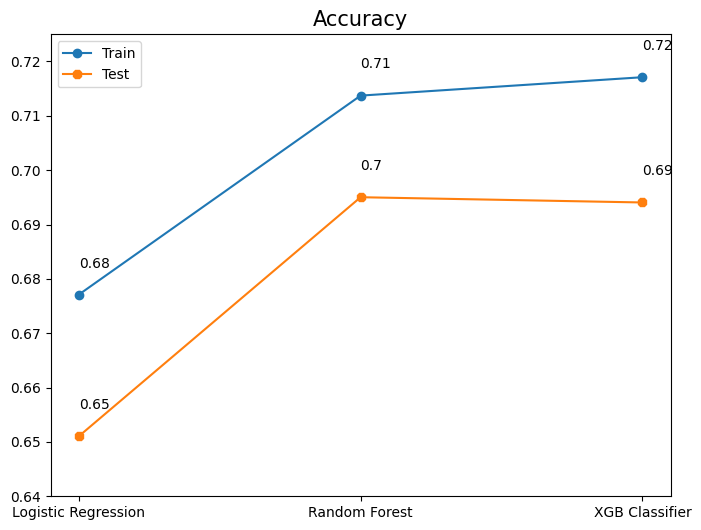

In [7]:
x = ['Logistic Regression', 'Random Forest', 'XGB Classifier']
y1 = [y_train_logistic_regression_accuracy, y_train_random_forest_accuracy, y_train_xgbclassifier_accuracy]
y2 = [y_test_logistic_regression_accuracy, y_test_random_forest_accuracy, y_test_xgbclassifier_accuracy]

plt.figure(figsize=(8,6))
plt.plot(x, y1, label='Train', marker='o')
for model, accuracy in zip(x, y1):
    plt.annotate(round(accuracy,2), xy=(model, accuracy + 0.005))

plt.plot(x, y2, label='Test', marker='8')
for model, accuracy in zip(x, y2):
    plt.annotate(round(accuracy,2), xy=(model, accuracy + 0.005))

plt.title('Accuracy', fontsize=15)
plt.ylim(0.64,0.725)
plt.legend();

### Findings

*   Logistic Regression fares the worst out of all 3 models
*   XGB does the best on train while random forest does the best on test
*   Based on the accuracy score, I will pick Random Forest as my model due to the performance on both the train and test set

### Precision / Recall

In [8]:
# Scoring for train
y_train_logistic_regression_predict_proba = logistic_regression.predict_proba(X_train)[:,1]
y_train_random_forest_predict_proba = random_forest_classifier.predict_proba(X_train)[:,1]
y_train_xgbclassifier_predict_proba = xgbclassifier.predict_proba(X_train)[:,1]

# Scoring for test
y_test_logistic_regression_predict_proba = logistic_regression.predict_proba(X_test)[:,1]
y_test_random_forest_predict_proba = random_forest_classifier.predict_proba(X_test)[:,1]
y_test_xgbclassifier_predict_proba = xgbclassifier.predict_proba(X_test)[:,1]

# Calculating precision,recall for train
y_train_logistic_regression_precision, y_train_logistic_regression_recall, thresholds = precision_recall_curve(y_true=y_train, probas_pred=y_train_logistic_regression_predict_proba)
y_train_random_forest_precision, y_train_random_forest_recall, thresholds = precision_recall_curve(y_true=y_train, probas_pred=y_train_random_forest_predict_proba)
y_train_xgbclassifier_precision, y_train_xgbclassifier_recall, thresholds = precision_recall_curve(y_true=y_train, probas_pred=y_train_xgbclassifier_predict_proba)

# Calculating precision,recall for test
y_test_logistic_regression_precision, y_test_logistic_regression_recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_test_logistic_regression_predict_proba)
y_test_random_forest_precision, y_test_random_forest_recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_test_random_forest_predict_proba)
y_test_xgbclassifier_precision, y_test_xgbclassifier_recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_test_xgbclassifier_predict_proba)

# Calculating AUC for train
y_train_logistic_regression_auc = round(auc(y_train_logistic_regression_recall, y_train_logistic_regression_precision) ,2)
y_train_random_forest_auc = round(auc(y_train_random_forest_recall, y_train_random_forest_precision) ,2)
y_train_xgbclassifier_auc = round(auc(y_train_xgbclassifier_recall, y_train_xgbclassifier_precision) ,2)

# Calculating AUC for test
y_test_logistic_regression_auc = round(auc(y_test_logistic_regression_recall, y_test_logistic_regression_precision) ,2)
y_test_random_forest_auc = round(auc(y_test_random_forest_recall, y_test_random_forest_precision) ,2)
y_test_xgbclassifier_auc = round(auc(y_test_xgbclassifier_recall, y_test_xgbclassifier_precision) ,2)

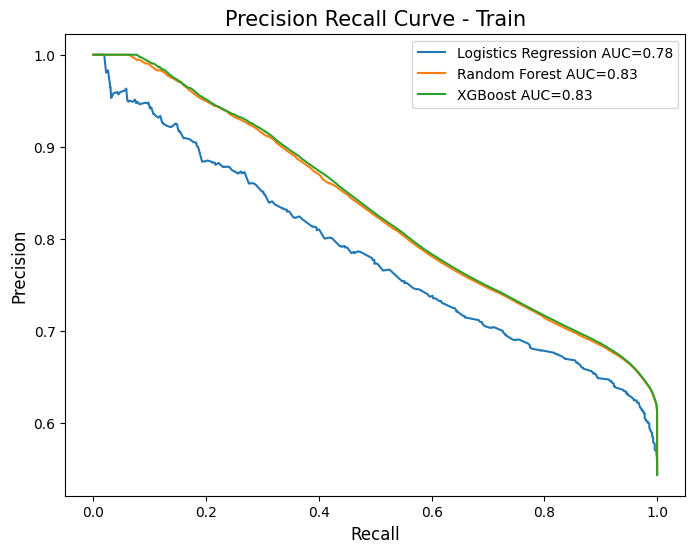

In [9]:
# Setting figure size
plt.figure(figsize=(8,6))

# Plotting PR Curve for all 3 models
plt.plot(y_train_logistic_regression_recall, y_train_logistic_regression_precision, label=f'Logistics Regression AUC={y_train_logistic_regression_auc}')
plt.plot(y_train_random_forest_recall, y_train_random_forest_precision, label=f'Random Forest AUC={y_train_random_forest_auc}')
plt.plot(y_train_xgbclassifier_recall, y_train_xgbclassifier_precision, label=f'XGBoost AUC={y_train_xgbclassifier_auc}')

# Adding legend, title and labels
plt.legend()
plt.title('Precision Recall Curve - Train', fontsize=15)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12);

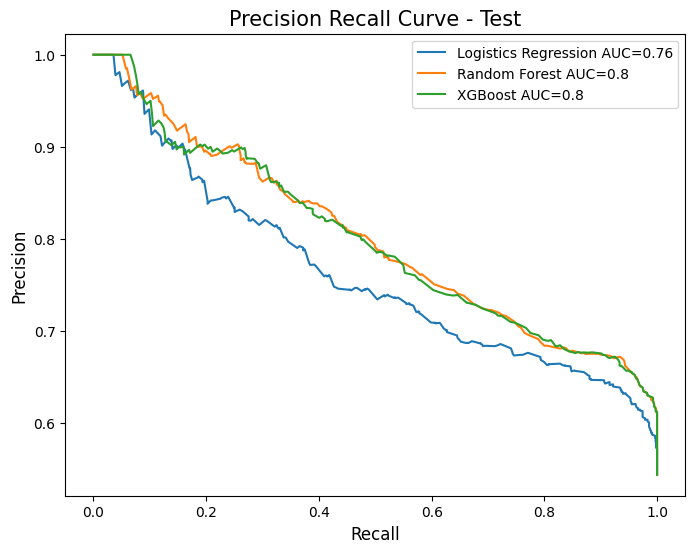

In [10]:
# Setting figure size
plt.figure(figsize=(8,6))

# Plotting PR Curve for all 3 models
plt.plot(y_test_logistic_regression_recall, y_test_logistic_regression_precision, label=f'Logistics Regression AUC={y_test_logistic_regression_auc}')
plt.plot(y_test_random_forest_recall, y_test_random_forest_precision, label=f'Random Forest AUC={y_test_random_forest_auc}')
plt.plot(y_test_xgbclassifier_recall, y_test_xgbclassifier_precision, label=f'XGBoost AUC={y_test_xgbclassifier_auc}')

# Adding legend, title and labels
plt.legend()
plt.title('Precision Recall Curve - Test', fontsize=15)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12);

### Findings

*   Although the data set is almost balanced, I plot the precision recall curve to see the performance among the models for the mentioned metrics
*   XGBoost performs marginally better on the train data than random forest although the AUC for both models are equal
*   However for the test set, it is a mixed bag
*   Just like the accuracy score, logistics regression fares the worst

### ROC Curve

In [11]:
# Defining for no skill
ns_probs_train = [0 for _ in range(len(y_train))]
ns_probs_test = [0 for _ in range(len(y_test))]

# Calculating FPR, TPR for train
y_train_ns_fpr, y_train_ns_tpr, _ = precision_recall_curve(y_true=y_train, probas_pred=ns_probs_train)
y_train_logistic_regression_fpr, y_train_logistic_regression_tpr, _ = precision_recall_curve(y_true=y_train, probas_pred=y_train_logistic_regression_predict_proba)
y_train_random_forest_fpr, y_train_random_forest_tpr, _ = precision_recall_curve(y_true=y_train, probas_pred=y_train_random_forest_predict_proba)
y_train_xgbclassifier_fpr, y_train_xgbclassifier_tpr, _ = precision_recall_curve(y_true=y_train, probas_pred=y_train_xgbclassifier_predict_proba)

# Calculating FPR, TPR for test
y_test_ns_fpr, y_test_ns_tpr, _ = precision_recall_curve(y_true=y_test, probas_pred=ns_probs_test)
y_test_logistic_regression_fpr, y_test_logistic_regression_tpr, _ = precision_recall_curve(y_true=y_test, probas_pred=y_test_logistic_regression_predict_proba)
y_test_random_forest_fpr, y_test_random_forest_tpr, _ = precision_recall_curve(y_true=y_test, probas_pred=y_test_random_forest_predict_proba)
y_test_xgbclassifier_fpr, y_test_xgbclassifier_tpr, _ = precision_recall_curve(y_true=y_test, probas_pred=y_test_xgbclassifier_predict_proba)

# Calculating AUC for train
y_train_ns_auc = round(roc_auc_score(y_true=y_train, y_score=ns_probs_train) ,2)
y_train_logistic_regression_auc = round(roc_auc_score(y_true=y_train, y_score=y_train_logistic_regression_predict_proba) ,2)
y_train_random_forest_auc = round(roc_auc_score(y_true=y_train, y_score=y_train_random_forest_predict_proba) ,2)
y_train_xgbclassifier_auc = round(roc_auc_score(y_true=y_train, y_score=y_train_xgbclassifier_predict_proba) ,2)

# Calculating AUC for test
y_test_ns_auc = round(roc_auc_score(y_true=y_test, y_score=ns_probs_test) ,2)
y_test_logistic_regression_auc = round(roc_auc_score(y_true=y_test, y_score=y_test_logistic_regression_predict_proba) ,2)
y_test_random_forest_auc = round(roc_auc_score(y_true=y_test, y_score=y_test_random_forest_predict_proba) ,2)
y_test_xgbclassifier_auc = round(roc_auc_score(y_true=y_test, y_score=y_test_xgbclassifier_predict_proba) ,2)

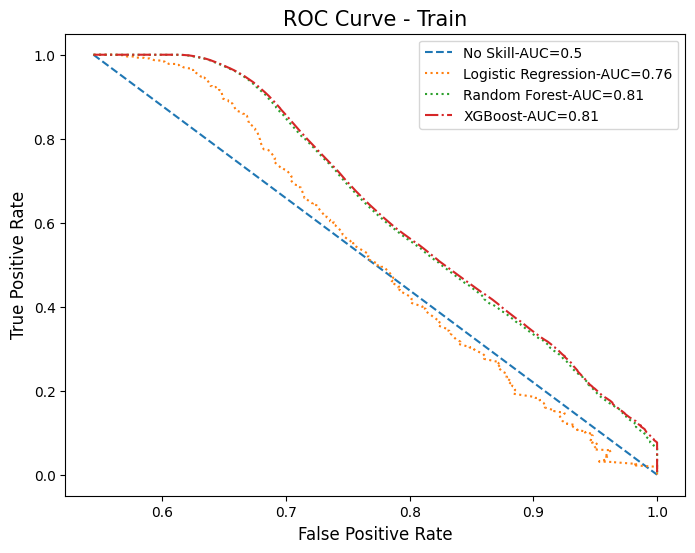

In [12]:
# Setting figure size
plt.figure(figsize=(8,6))

# Plotting TPR vs FPR Curve for all 3 models
plt.plot(y_train_ns_fpr, y_train_ns_tpr, linestyle='--', label=f'No Skill-AUC={y_train_ns_auc}')
plt.plot(y_train_logistic_regression_fpr, y_train_logistic_regression_tpr, linestyle=':', label=f'Logistic Regression-AUC={y_train_logistic_regression_auc}')
plt.plot(y_train_random_forest_fpr, y_train_random_forest_tpr, linestyle='dotted', label=f'Random Forest-AUC={y_train_random_forest_auc}')
plt.plot(y_train_xgbclassifier_fpr, y_train_xgbclassifier_tpr, linestyle='-.', label=f'XGBoost-AUC={y_train_xgbclassifier_auc}')

# Adding legend, title and labels
plt.legend()
plt.title('ROC Curve - Train', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12);

### Findings

*   The No Skill plot depicts randomly picking lung cancer occurence
*   As expected, XGboost and random forest outperforms logtistic regression

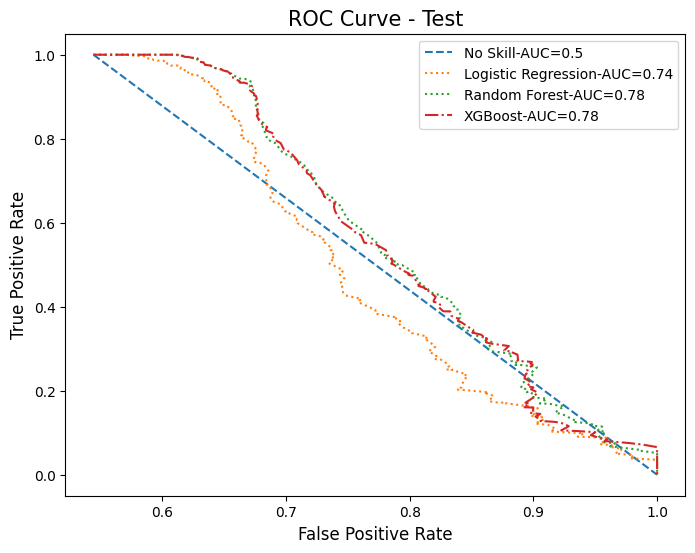

In [13]:
# Setting figure size
plt.figure(figsize=(8,6))

# Plotting TPR vs FPR Curve for all 3 models
plt.plot(y_test_ns_fpr, y_test_ns_tpr, linestyle='--', label=f'No Skill-AUC={y_test_ns_auc}')
plt.plot(y_test_logistic_regression_fpr, y_test_logistic_regression_tpr, linestyle=':', label=f'Logistic Regression-AUC={y_test_logistic_regression_auc}')
plt.plot(y_test_random_forest_fpr, y_test_random_forest_tpr, linestyle='dotted', label=f'Random Forest-AUC={y_test_random_forest_auc}')
plt.plot(y_test_xgbclassifier_fpr, y_test_xgbclassifier_tpr, linestyle='-.', label=f'XGBoost-AUC={y_test_xgbclassifier_auc}')

# Adding legend, title and labels
plt.legend()
plt.title('ROC Curve - Test', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12);

### Findings

*   All models fare worst on the test relative to the train
*   However, Random Forest and XGBoost are the same with slight variations

### Classification Report

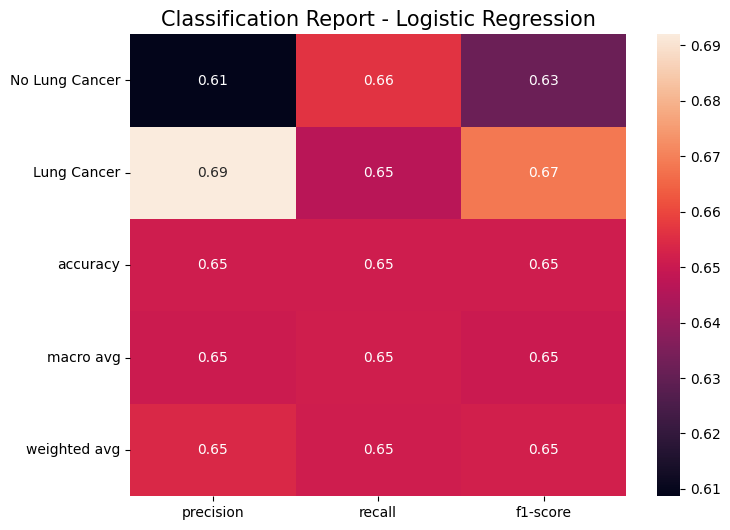

In [14]:
# Obtaining classification report
clf_report = classification_report(y_true=y_test, y_pred=y_test_logistic_regression_predict, target_names=['No Lung Cancer', 'Lung Cancer'], output_dict=True)

# Setting figure size
plt.figure(figsize=(8,6))

# Plotting heatmap of classification report
sns.heatmap(data=pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# Adding title
plt.title('Classification Report - Logistic Regression', fontsize=15);

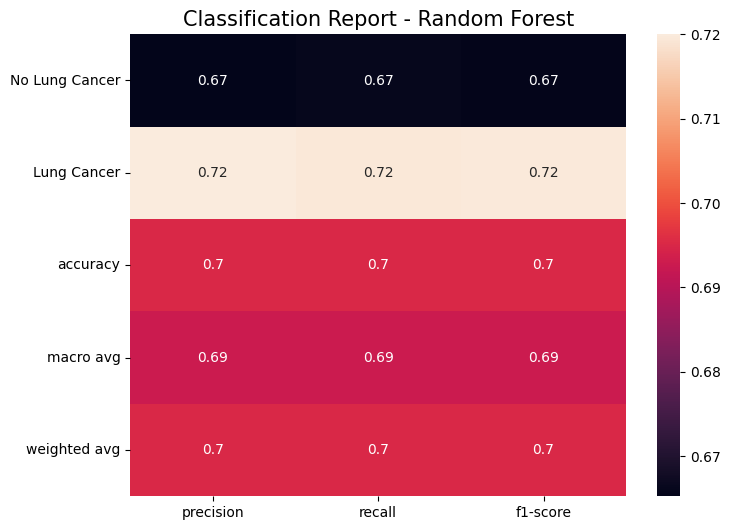

In [15]:
# Obtaining classification report
clf_report = classification_report(y_true=y_test, y_pred=y_test_random_forest_predict, target_names=['No Lung Cancer', 'Lung Cancer'], output_dict=True)

# Setting figure size
plt.figure(figsize=(8,6))

# Plotting heatmap of classification report
sns.heatmap(data=pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# Adding title
plt.title('Classification Report - Random Forest', fontsize=15);

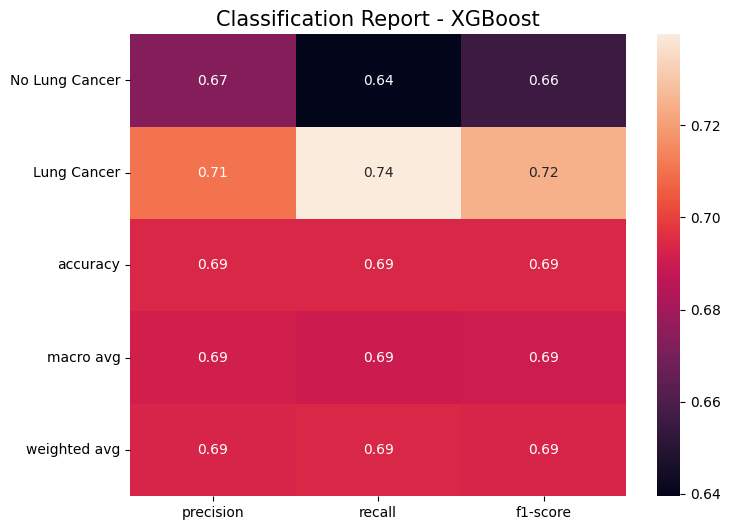

In [16]:
# Obtaining classification report
clf_report = classification_report(y_true=y_test, y_pred=y_test_xgbclassifier_predict, target_names=['No Lung Cancer', 'Lung Cancer'], output_dict=True)

# Setting figure size
plt.figure(figsize=(8,6))

# Plotting heatmap of classification report
sns.heatmap(data=pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# Adding title
plt.title('Classification Report - XGBoost', fontsize=15);

### Findings

*   The classification reports among the different models show that Logistic Regression fare the worst among all 3 models
*   While the Random Forest model is consistent among precision, recall and F1 score for Lung Cancer and no Lung Cancer, XGBoost numbers are rather erratic

### Confusion Matrix

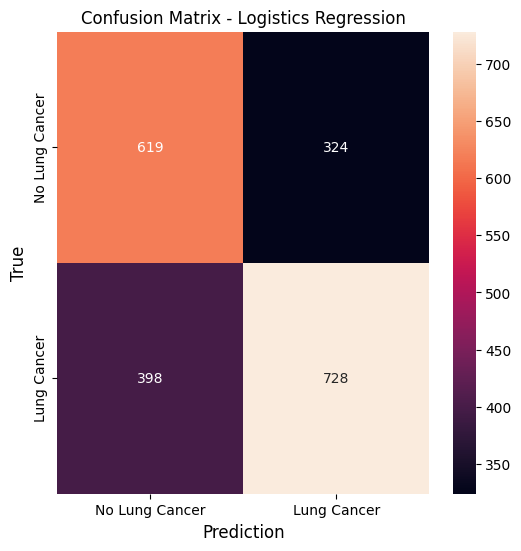

In [42]:
# Obtaining confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_logistic_regression_predict)

# Setting figure size
plt.figure(figsize=(6,6))

# Plotting
ax = plt.subplot()
sns.heatmap(data=cm, annot=True, fmt='g')

# Setting labels
ax.xaxis.set_ticklabels(['No Lung Cancer', 'Lung Cancer'])
ax.yaxis.set_ticklabels(['No Lung Cancer', 'Lung Cancer'])
ax.set_xlabel('Prediction', fontsize = 12)
ax.set_ylabel('True', fontsize = 12)

# Setting title
plt.title('Confusion Matrix - Logistics Regression');

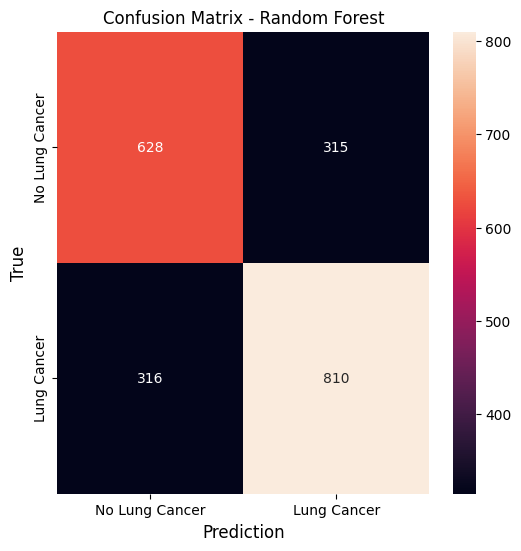

In [43]:
# Obtaining confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_random_forest_predict)

# Setting figure size
plt.figure(figsize=(6,6))

# Plotting
ax = plt.subplot()
sns.heatmap(data=cm, annot=True, fmt='g')

# Setting labels
ax.xaxis.set_ticklabels(['No Lung Cancer', 'Lung Cancer'])
ax.yaxis.set_ticklabels(['No Lung Cancer', 'Lung Cancer'])
ax.set_xlabel('Prediction', fontsize = 12)
ax.set_ylabel('True', fontsize = 12)

# Setting title
plt.title('Confusion Matrix - Random Forest');

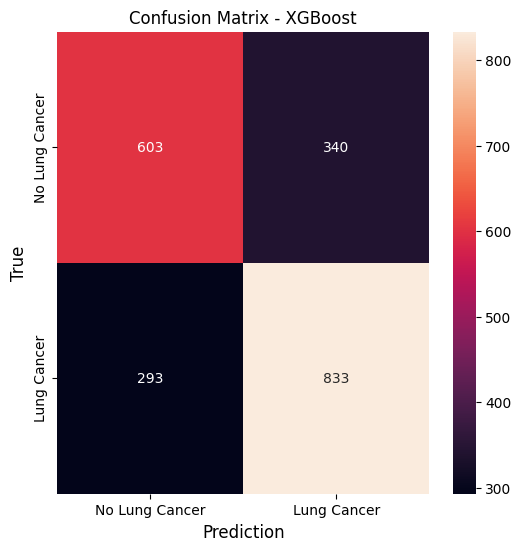

In [44]:
# Obtaining confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_xgbclassifier_predict)

# Setting figure size
plt.figure(figsize=(6,6))

# Plotting
ax = plt.subplot()
sns.heatmap(data=cm, annot=True, fmt='g')

# Setting labels
ax.xaxis.set_ticklabels(['No Lung Cancer', 'Lung Cancer'])
ax.yaxis.set_ticklabels(['No Lung Cancer', 'Lung Cancer'])
ax.set_xlabel('Prediction', fontsize = 12)
ax.set_ylabel('True', fontsize = 12)

# Setting title
plt.title('Confusion Matrix - XGBoost');

### Findings

*   The logistic regression fares worst in False Negative
*   While the same can be said of Random Forest, XGBoost model sings a different tune by faring worst in False Positive
*   Comparing XGBoost against Random Forest, while the former does better in false negative, the latter does better in false positive

## Conclusion

*   Among all 3 models, Random Forest is my model of choice
*   By process of elimination, Logistic Regression is out of the race
*   However it is a tight race between Random Forest and XGBoost, I choose the former due to its performance in both the train and test set

# Model Intepretability

*   Since Random Forest is my model of Choice, I will utilise SHAP values to interpret the model

ExactExplainer explainer: 8276it [03:43, 35.37it/s]                          


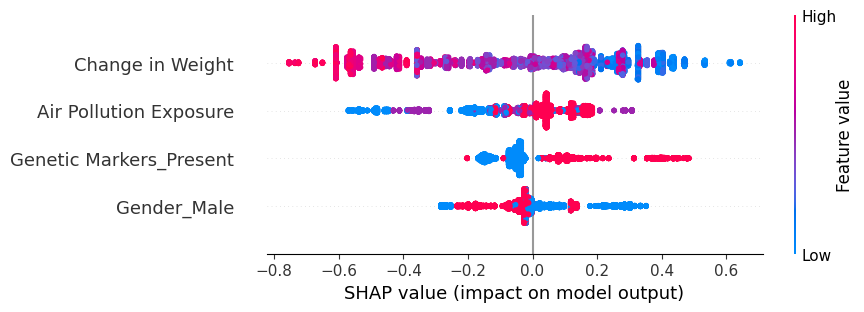

In [51]:
explainer = shap.Explainer(random_forest_classifier.predict, X_train)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

ExactExplainer explainer: 2070it [00:56, 30.01it/s]                          


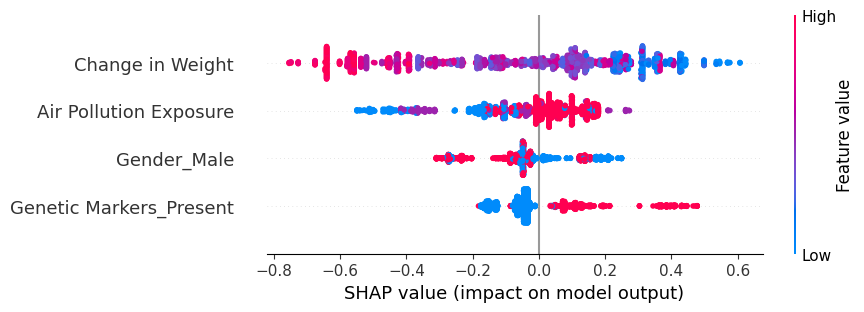

In [52]:
explainer = shap.Explainer(random_forest_classifier.predict, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

### Findings

*   Among the train and test set, Genetics Markets is more important than Gender for Train
*   However for test, it is vice versa
*   A larger weight loss will lead to a lower chance of getting lung cancer as evidenced by the red points all the way to the left
*   For Air Pollution Exposure, it is intuitive, more exposure to Air Pollution will have a higher chance of getting Lung Cancer
*   The same for the presence of Genetic Markers